# **Hopfield Networks** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TomGeorge1234/HopfieldNetworkTutorial/blob/main/hopfield_networks.ipynb)
### **TReND CaMinA, Computational Neuroscience and Machine Learning Summer School, 2024**
#### made by: **Tom George, UCL**

In this tutorial we'll build and train Hopfield networks. By the end we'll have a network which can memorise flags from all 54 African Nations.

<center><img src="https://github.com/TomGeorge1234/HopfieldNetworkTutorial/blob/main/images/hfn.gif?raw=1" width=1000></center>

## **Learning Objectives**
* Understand Hopfield Network
* Build a basic Hopfield Network so memorize random binary patterns
* Explore the behaviours and limitations of these Hopfield Networks
* Build a "Modern" Hopfield Network and train it to memorise flags
</div>

## **Contents**
0. [Import dependencies and data](#dependencies)
1. [Making random patterns](#random-patterns)
2. [Making a basic Hopfield Network](#hopfield)
    1. [Weight matrix](#weights)
    2. [Update function](#update)
    3. [Energy function](#energy)
3. [Testing the Hopfield Network](#testing)
    1. [Pattern stability](#stability)
    2. [Pattern denoising](#denoising)
    3. [Pattern completion](#completion)
    4. [Negative patterns](#negative)
    5. [Spurious states](#spurious)
    6. [Strong patterns](#strong)
    7. [Memory capacity](#capacity)
    8. [Complex patterns (flags)](#flags)
4. [Modern Hopfield Networks](#modern)
    1. [Flag Championship!](#flag-championship)
    2. [Inverse "temperature"](#temperature)

---
## **0. Importing dependencies and data** <a name="dependencies"></a>
Run the following code: It'll install some dependencies, download some files and import some functions. You can mostly ignore it.

In [2]:
#@title Run this code, but feel free to ignore it. {display-mode: "form" }
!pip install numpy matplotlib ipywidgets tqdm wget

%load_ext autoreload
%autoreload 2

#import a load of helper / plotting functions this tutorial uses but you don't need to worry about
import os
import wget
import pickle

#if running on colab we need to download the data and utils files

#downloads the utils functions
if os.path.exists("hopfield_networks_utils.py"): pass
else: wget.download("https://github.com/TomGeorge1234/HopfieldNetworkTutorial/raw/main/hopfield_networks_utils.py"); print("...utils downloaded!")

#downloafs the flags data
if os.path.exists("flags_of_africa.pickle"): pass
else: wget.download("https://github.com/TomGeorge1234/HopfieldNetworkTutorial/raw/main/flags_of_africa.pickle"); print("...flags downloaded!")

#downloads other images used in the notebook
if os.path.isdir("./images"): pass
else:
    wget.download("https://github.com/TomGeorge1234/HopfieldNetworkTutorial/raw/main/images.zip")
    !unzip -o images.zip
    print("...images downloaded and unzipped!")
print("Done!")

from hopfield_networks_utils import *


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=146b65a5103582f83818c895a27b20008f3f5c7ac9af9de6861e4e18c5ead06f
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
...utils downloaded!
...flags downloaded!
Archive:  images.zip
   creating: images/
  inflating: images/hfn.gif          
  inflating: images/strong_patterns.png  
  inflating: images/memory_threshold.png  
  inflating: images/hopfield_dynamics.png  
  inflating: images/spurious_states.png  
...images downloaded and unzipped!
Done!


---
## **1. Making random binary patterns** <a name="random-patterns"></a>

Hopfield networks were some of the earliest computational models of memory.

A Hopfield network contains many recurrently connected neurons which talk to each other.

They store a set of memories $\{ \xi_i^{(n)} \}$ for $n \in [1,N_{\textrm{patterns}}]$.

We'll start off by training a _classical_ (binary) Hopfield network to store 5 patterns.
* Each patterns will be a 6 x 6 random binary pattern.
* These will be stored in a python dictionary `random_patterns`
* We can visualise them by calling `plot_patterns(random_patterns)`


Text(0.5, 0.98, 'These are 5 patterns our network will memorize')

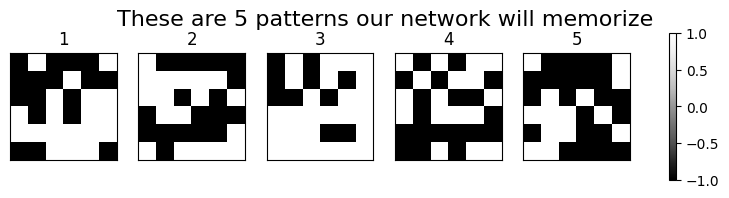

In [3]:
#Create 5 random patterns
np.random.seed(42)
N_patterns = 5
pattern_size = (6,6)
random_patterns = {str(i) : np.random.choice([-1,1],size=pattern_size) for i in range(1,N_patterns+1)}

fig, ax = plot_patterns(random_patterns)
fig.suptitle(f"These are {random_patterns.__len__()} patterns our network will memorize", fontsize=16)

---
## **2.0 Making a Hopfield Network** <a name="hopfield"></a>

Below we provide some basic code defining a Hopfield Network class.
You don't need to understand this but it'll be useful to know what important attributes and functions it contains.

Suppose we initialise a network `HFN = HopfieldNetwork(random_patterns)`

**Important attributes**

* `HFN.state` is the current state of the network, a vector $s \in \mathbb{R}^{N_{\textrm{neurons}}}$
* `HFN.w` is the synpatic weight matrix.
* `HFN.patterns` is a matrix containing all the patterns in their original shape
* `HFN.N_neurons` how many neurons the network has
* `HFN.flattened_patterns` is a matrix of stored _flattened_ patterns $\Xi \in \mathbb{R}^{N_{\textrm{Patterns}} \times N_{\textrm{neurons}}}$ such that $\Xi_{n,i} \equiv \xi^{(n)}_{i}$ is the $i^{\textrm{th}}$ element of the $n^{\textrm{th}}$ pattern.
* `HFN.similarities` is a measure of similarity (a number from 0 to 1) between the current state and all saved patterns, $\textrm{sim} \in \mathbb{R}^{N_{\textrm{patterns}}}$.
* `HFN.energy` is the energy of the current state of the Hopfield network
* `HFN.history` is a dictionary containing all past `state`s,  `similarity`s and `energy`s of the network.

**Important methods**

* `HFN.update_state()`: Takes the current state and updates it $s(t) \leftarrow s(t+1)$. Then, the `state` and `similarities` are saved to history. <span style="color:red"> _[TO DO: NOT YET DEFINED]_ </span>
* `HFN.set_state(state)`: Sets the state of the network to whatever you pass as `state`. Alternatively pass HFN.set_state(random=True)` to reinitialise.
* `HFN.visualise()`: Displays the current state of the network next to a bar chart of how similar it is to all the saved patterns.
* `HFN.plot_energy(n_steps)`: Plots the evolution of the energy of the Hopfield netowrk over the past `n_steps`
* `HFN.animate(n_steps)`: Makes a short video displaying the evolution of the state of the network over the past `n_steps`

In [5]:
help(BaseHopfieldNetwork)

Help on class BaseHopfieldNetwork in module hopfield_networks_utils:

class BaseHopfieldNetwork(builtins.object)
 |  BaseHopfieldNetwork(patterns_dict)
 |  
 |  Base class for our Hopfield Network (Modern) Hopfield Network
 |  
 |  Methods defined here:
 |  
 |  __init__(self, patterns_dict)
 |      Initialises the Hopfield network with a set of patterns. It loads
 |      Args:
 |          • patterns: a dictionary containing the patterns to be stored in the network labelled by their names. Patterns can be any shape, they will be flattened into vectors during initialisation.
 |  
 |  animate(self, n_steps=10, fps=10, animation_length_secs=5)
 |      Animates the last n_steps of the Hopfield network. fps gives frames per socond of resulting animation
 |  
 |  get_energy(self, state=None)
 |      Returns the energy of the network at a given state
 |  
 |  get_similarities(self, state=None)
 |      Compares the state (defaults to the current state of the network to all stored patterns and 

In [4]:
dir(BaseHopfieldNetwork)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'animate',
 'get_energy',
 'get_similarities',
 'plot_energy',
 'save_history',
 'set_state',
 'update_state',
 'visualise']

In [6]:
class HopfieldNetwork(BaseHopfieldNetwork):
    """A (Modern) Hopfield Network"""
    def __init__(self,patterns_dict):

        """Initialises the Hopfield network with a set of patterns.
        Args:
            • patterns: a dictionary containing the p']atterns to be stored in the network labelled by their names.
            Patterns can be any shape, they will be flattened into vectors during initialisation.

        The rest of the code has already been written for us!"""
        super().__init__(patterns_dict) # all of the code has
        return

In [7]:
HFN = HopfieldNetwork(random_patterns)

**_📝TASKS_**
1. Print the state of the Hopfield Network using `HFN.state`
2. Visualise the state of the Hopfield Network using `HFN.visualise()`. What do you see?

In [9]:
# Your code goes here
HFN.state, len(HFN.state)

(array([-1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,
        -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1.,
         1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.]),
 36)

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'Network activity pattern'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

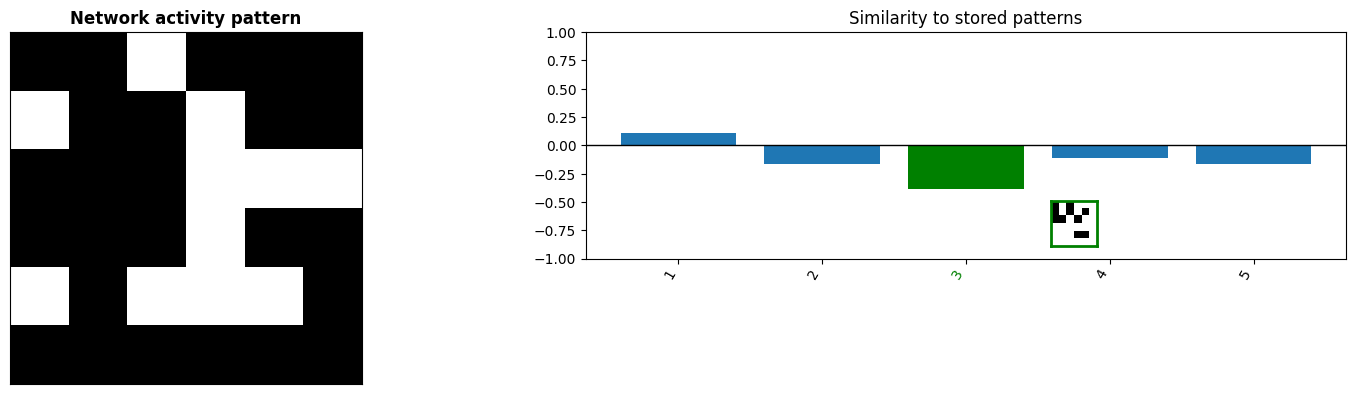

In [10]:
HFN.visualise()

### **2.1 Setting the weight matrix** <a name="weights"></a>

Recall from the lecture than in order to remember a set of patterns the weight matrix should be set as follows:

$$ w_{ij} = \sum_{n}\xi_{i}^{(n)} \xi_{j}^{(n)} $$

> **_📝TASK_** Write this matrix in python code. Hint: you may like to use the `HFN.flattened_patterns` to access an array of the patternss.

In [11]:
dir(HFN)

['N_neurons',
 'N_patterns',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'animate',
 'energy',
 'flattened_patterns',
 'get_energy',
 'get_similarities',
 'history',
 'pattern_names',
 'pattern_shape',
 'patterns',
 'patterns_dict',
 'plot_energy',
 'save_history',
 'set_state',
 'similarities',
 'state',
 'update_state',
 'visualise',
 'w']

In [12]:
#@title Double click to see solution {display-mode: "form" }
# ==== SOLUTION ====
w = HFN.flattened_patterns.T @ HFN.flattened_patterns
# ==================

### **2.2 The update function** <a name="update"></a>

Recall from the lecture that the update function for a Hopfield Network is as follows:

1. Choose a random neuron, $i$
2. Update the value of the neuron according to
$$s_{i}(t+1) = \textrm{sign}\big(\sum_{j}w_{ij}s_{j}(t)\big)$$

**_📝TASK_** Complete the following code replica code for the `HFN.update_state()` function.

In [ ]:
# First: Choose a random neuron between 1 and HFN.N_neurons
i = #you code goes here

# Second: Update the neuron
w = HFN.w
state = HFN.state

state[i] = # your code goes here

In [14]:
#@title Double click for the solution {display-mode: "form" }
# First: Choose a random neuron between 1 and HFN.n
i = np.random.randint(0,HFN.N_neurons)

# Second: Update the neuron
w = HFN.w
state = HFN.state

state[i] = np.sign(w[i,:]@state)# your code goes here

### **2.3 The Energy function** <a name="energy"></a>
The "energy" of the Hopfiled network is defined as

$$E(\mathbf{s}) = -\frac{1}{2} \sum_{i}\sum_{j} s_{i} w_{ij} s_j$$

It's useful because:
* It can only ever decrease (we must find a minima eventually)
* The patterns, $\xi_{i}^{(n)}$, are _stable minima_ of the energy function

**_📝TASK_** Complete the following code which calculates the energy function. Hint you may like to use `HFN.state` and `HFN.w` to calculate it. Compare it to the correct value given by `HFN.get_energy(HFN.state)`

In [ ]:
state = HFN.state
w = HFN.w

E = NotImplemented #Put your code here

In [16]:
#@title Double click to see solution {display-mode: "form" }
# ==== SOLUTION =========================
E =  -0.5 * HFN.state @ HFN.w @ HFN.state
# =======================================

In [17]:
assert E == HFN.get_energy(HFN.state), "Sorry, your energy is not correct 🥲"
print("Well done! Your energy calculation is correct!")

Well done! Your energy calculation is correct!


---
## **3. Testing the Hopfield Network** <a name="testing"></a>

In [19]:
HFN = HopfieldNetwork(random_patterns)

Congratulations! You just built your first Hopfield  Network. Lets test it out.

In the upcoming sections we're going to see a number of things:

3. [Testing the Hopfield Network](#testing)
    1. [Pattern stability](#stability): Patterns which are "memories" of the network are stable.
    2. [Pattern denoising](#denoising): The network recovers patterns it starts "near" to
    3. [Pattern completion](#completion): The network completes partial patterns
    4. [Negative patterns](#negative): Negative patterns are stable
    5. [Spurious states](#spurious): Mixtures of patterns are stable
    6. [Strong patterns](#strong): We can embed some patterns more strongly than others
    7. [Memory capacity](#capacity): Too many memories and the network starts to fail
    8. [Complex patterns (flags)](#flags): The network can't learn highly complex patterns.


First thing we'll try is initialising it _close_ to one of the stored patterns and seeing how it evolves:

### **3.1 Pattern stability** <a name="stability"></a>

The learned patterns should be stable fixed points of the system dynamics.

<center><img src="https://github.com/TomGeorge1234/HopfieldNetworkTutorial/blob/main/images/hopfield_dynamics.png?raw=1" width=500></center>

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'State after 200 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

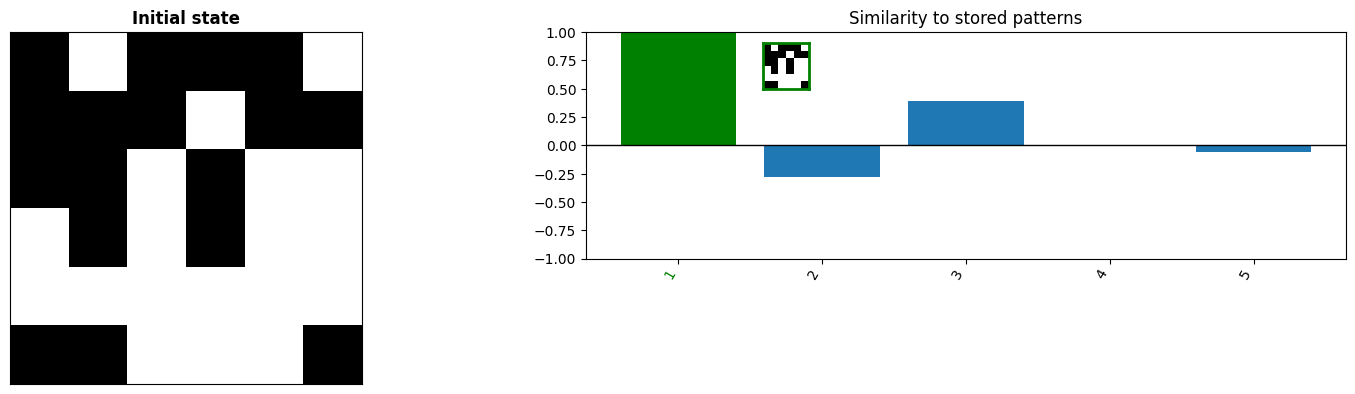

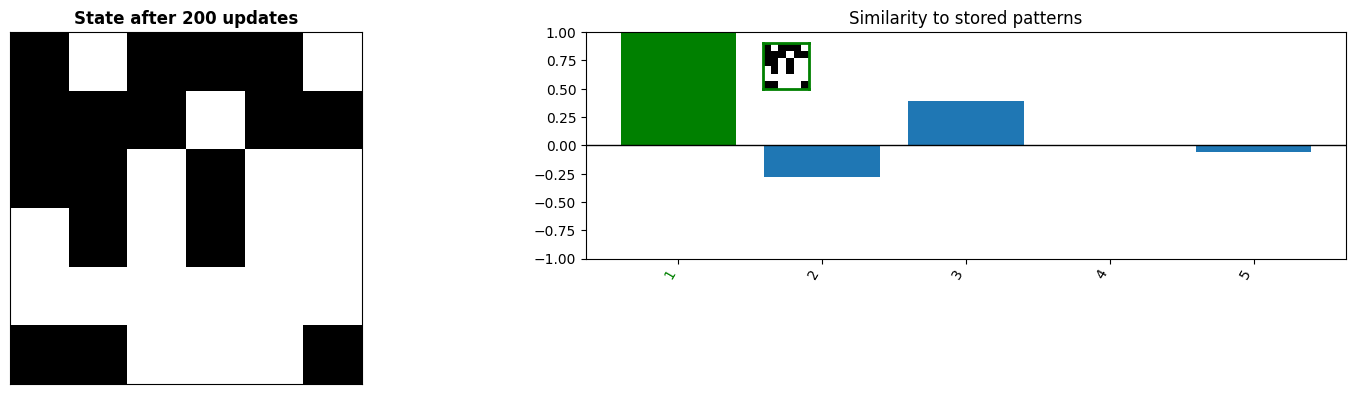

In [20]:
pattern_to_start = '1'

HFN.set_state(random_patterns[pattern_to_start].flatten()) #reinitialise the state of the network
HFN.visualise(title="Initial state")
for i in range(200):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")

n_steps: 200


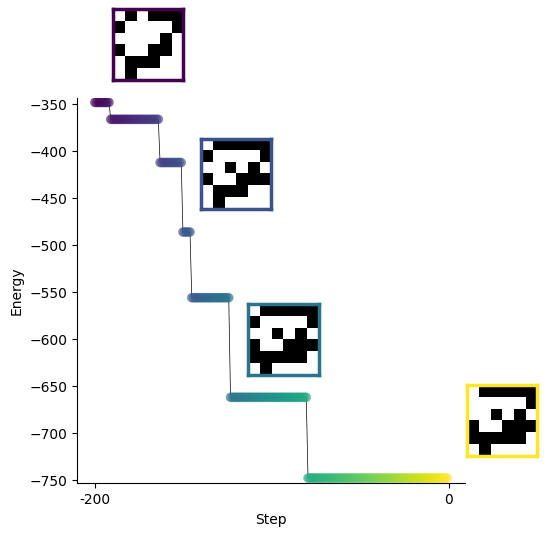

In [22]:
fig, ax = HFN.plot_energy(n_steps=200)

### **3.2 Pattern denoising**  <a name="stability"></a>

Better yet...if we start _near_ one of the saved patterns.
We'll do this by randomly flipping X-% of our bits.

n_steps: 200


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

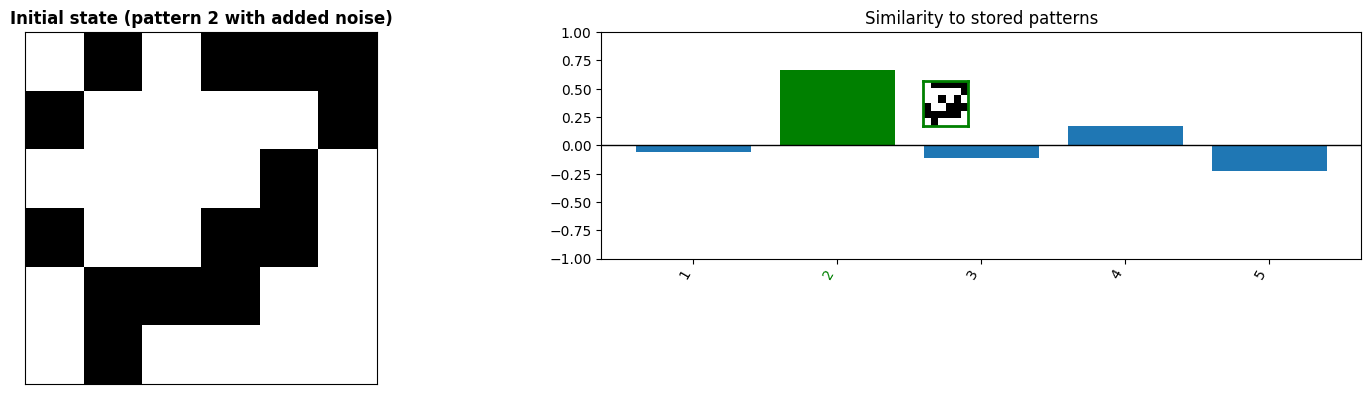

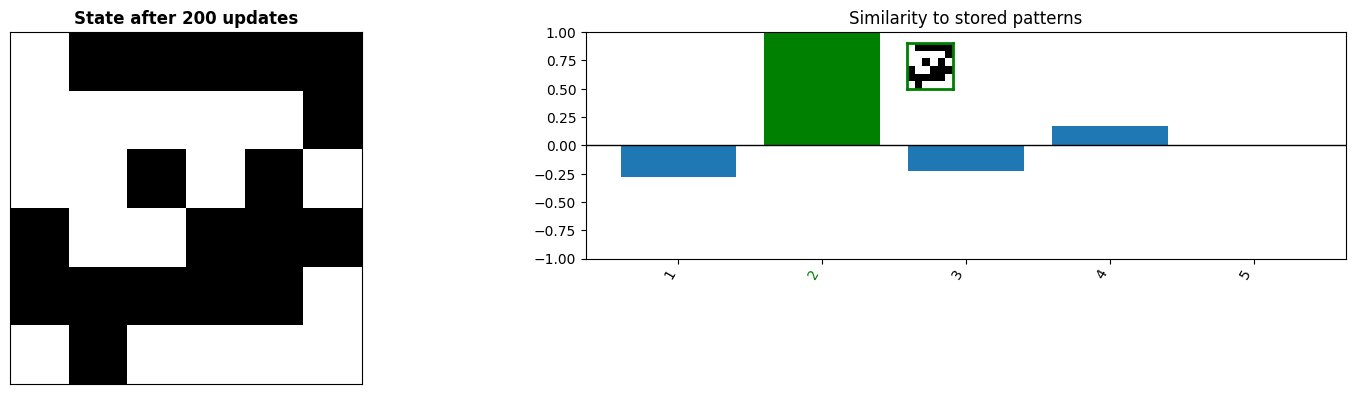

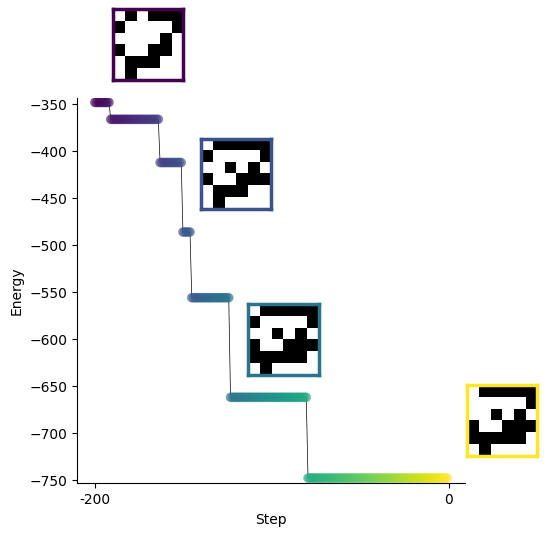

In [21]:
pattern_to_start = '2'
X = 20 # percentage of bits to flip

noisy_state = random_patterns[pattern_to_start].flatten() * np.random.choice([-1,1],p=[X/100,1-X/100],size=(HFN.N_neurons,))

HFN.set_state(noisy_state) #reinitialise the state of the network
HFN.visualise(title=f"Initial state (pattern {pattern_to_start} with added noise)")
for i in range(200):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")
HFN.plot_energy(n_steps=200)

Has it accurately recovered the pattern we started near?

**_📝TASK_** Try again but with `X=50`% of the pattern flipped. Dos it reliable recover the pattern now?

### **3.3 Pattern completion** <a name="completion"></a>
What if we occlude part of a pattern...will the network be able to retrieve the rest?
We can do this with the `mask_pattern()` function.

In [ ]:
pattern_to_start = '2'
partially_masked_pattern = mask_pattern(random_patterns[pattern_to_start])
HFN.set_state(partially_masked_pattern) #reinitialise the state of the network
HFN.visualise(title=f"Initial state (pattern {pattern_to_start} heavily masked)")
for i in range(200):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")

In [ ]:
HFN.plot_energy(n_steps=200)

### **3.4 Negative patterns** <a name="negative"></a>

Theory tells us negative patterns should be stable fixed points just like the original patterns. Let's test this.

In [ ]:
pattern_to_start = '2'

##### !!! #####
negative_pattern = -random_patterns[pattern_to_start] #note the negative sign
HFN.set_state(negative_pattern)
##### !!! #####

HFN.visualise(title=f"Initial state (pattern {pattern_to_start} inverted)")
for i in range(200):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")

### **3.5 Mixed states and spurious states** <a name="spurious"></a>

What happens if we try initialise the network in a mixed state. For example and mix of patterns 1, 2 and 3:

$$ s_i(0) := \xi_i^{\textrm{mix}} = \textrm{sgn} \big( \pm \xi_i^{(1)} \pm \xi_i^{(2)} \pm \xi_i^{(3)} \big)$$

<center><img src="https://github.com/TomGeorge1234/HopfieldNetworkTutorial/blob/main/images/spurious_states.png?raw=1" width=500></center>

In [ ]:
##### !!!!! #####
mixed_state = np.sign(random_patterns['1'].flatten() - random_patterns['2'].flatten() + random_patterns['3'].flatten())
##### !!!!! #####

HFN.set_state(mixed_state) #reinitialise the state of the network
HFN.visualise(title=f"Initial state (mixed patterns 1,2 & 3)")
for i in range(200):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")
HFN.plot_energy(n_steps = 200)

### **3.6 Strong patterns** <a name="strong"></a>

<center><img src="https://github.com/TomGeorge1234/HopfieldNetworkTutorial/blob/main/images/strong_patterns.png?raw=1" width=500></center>

We can embed some patterns into the network _more strongly_ than others.

* Here's a "smiley" face pattern.
* We'll embed _three times_ into the same network, along with 7 other random patterns.



Text(0.5, 0.98, 'The patterns we will learn. We purposefully bias towards one pattern more than others')

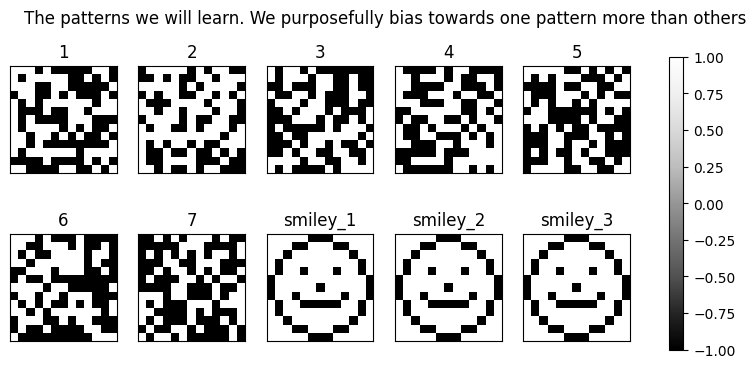

In [29]:
smiley_state = np.array([
    [ 1, 1, 1, 1, 1,-1,-1,-1, 1, 1, 1, 1, 1],
    [ 1, 1, 1,-1,-1, 1, 1, 1,-1,-1, 1, 1, 1],
    [ 1, 1,-1, 1, 1, 1, 1, 1, 1, 1,-1, 1, 1],
    [ 1,-1, 1, 1, 1, 1, 1, 1, 1, 1, 1,-1, 1],
    [ 1,-1, 1, 1,-1, 1, 1, 1,-1, 1, 1,-1, 1],
    [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,-1],
    [-1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1,-1],
    [-1, 1, 1,-1, 1, 1, 1, 1, 1,-1, 1, 1,-1],
    [ 1,-1, 1, 1,-1,-1,-1,-1,-1, 1, 1,-1, 1],
    [ 1,-1, 1, 1, 1, 1, 1, 1, 1, 1, 1,-1, 1],
    [ 1, 1,-1, 1, 1, 1, 1, 1, 1, 1,-1, 1, 1],
    [ 1, 1, 1,-1,-1, 1, 1, 1,-1,-1, 1, 1, 1],
    [ 1, 1, 1, 1, 1,-1,-1,-1, 1, 1, 1, 1, 1],
])

random_patterns = {str(i) : np.random.choice([-1,1],size=(13,13)) for i in range(1,7+1)}
random_patterns['smiley_1'] = smiley_state
random_patterns['smiley_2'] = smiley_state
random_patterns['smiley_3'] = smiley_state
fig, ax = plot_patterns(random_patterns)
fig.suptitle("The patterns we will learn. We purposefully bias towards one pattern more than others")

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'State after 1000 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

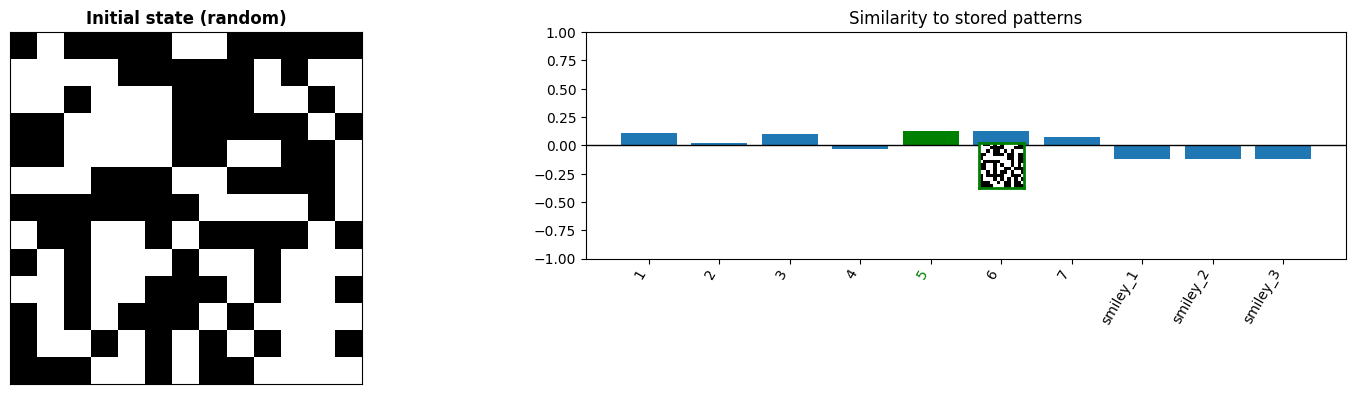

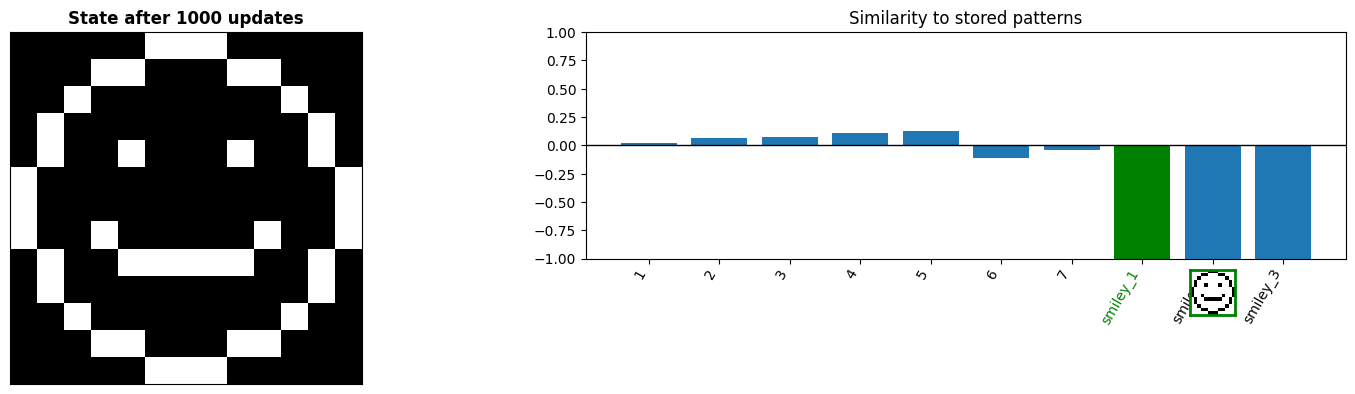

In [24]:
HFN = HopfieldNetwork(random_patterns)
HFN.set_state(random=True) #reinitialise the state of the network
HFN.visualise(title="Initial state (random)")
for i in range(1000):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")

Task: try running this many times...do you notice how it always (with v small error) converges on the smiley face pattern, not one of the other random patterns.

What does this tell us about the energy landscape and how might this relate to biological memories?

n_steps: 1000


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

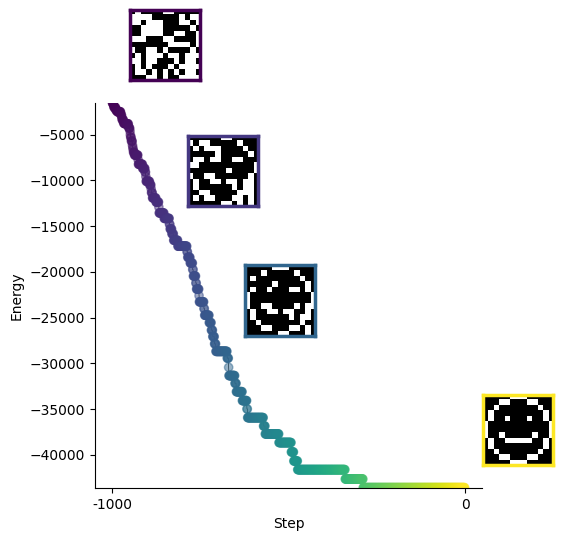

In [25]:
HFN.plot_energy(n_steps=1000)

We can animate this progression of states using the `HFN.animate()` method

In [ ]:
HFN.animate(n_steps=1000)

### **3.7 Testing the memory capacity** <a name="capacity"></a>

Lets try the same but in a network with **more patterns** and **fewer neurons**.

By doing so we may demonstrate some of the memory issues suffered by classical Hopfield networks.

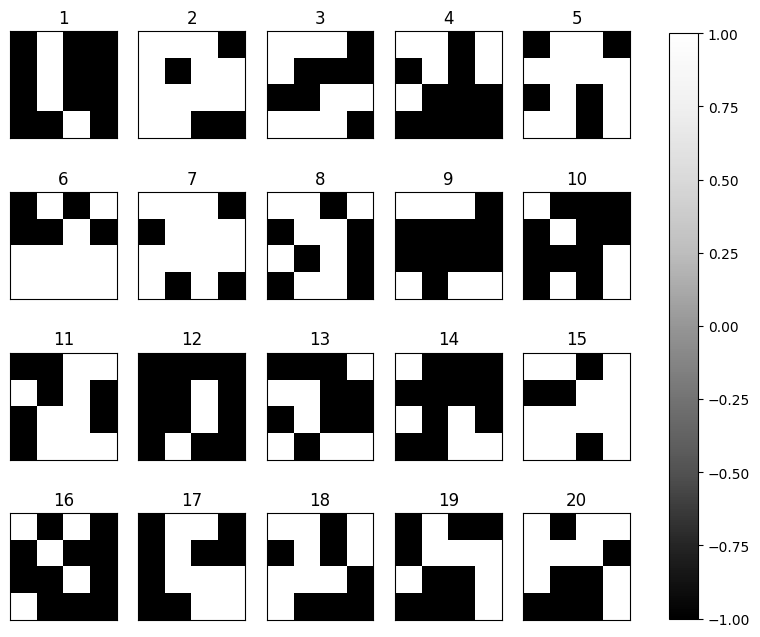

In [30]:
#Create 20 random patterns of size 4x4
np.random.seed(42)
N_patterns = 20
pattern_size = (4,4)
random_patterns_many = {str(i) : np.random.choice([-1,1],size=pattern_size) for i in range(1,N_patterns+1)}
fig, ax = plot_patterns(random_patterns_many)

HFN = HopfieldNetwork(random_patterns_many)

Theory has told us that the memory capacity of a Hopfield Network (roughly how many memories we can store before they become unstable) becomes an issue once the number of memories exceeds 13% the number of neurons.

$$ N_{\textrm{memories}} \sim 0.138 \times N_{\textrm{Neurons}} $$

Here we have
and for our 4 x 4 patterns there are 16 neurons...so we should expect errors to start piling up one we have more than $0.138 \times 36 \approx 5$ patterns!

In [ ]:
# test ALL the memories and set which ones are unstable
unstable_patterns = []
for pattern in random_patterns_many:
    HFN.set_state(random_patterns_many[pattern].flatten())
    initial_state = copy.deepcopy(HFN.state)
    for i in range(100):
        HFN.update_state(asynchronous=True)
    if not np.all(initial_state == HFN.state): #if a pattern is not stable, add it to the list
        unstable_patterns.append(pattern)

print(f"{100*len(unstable_patterns)/len(random_patterns_many):.1f}% of the memory patterns are unstable. These are {unstable_patterns}")

#visualise an unstable memory
if len(unstable_patterns) > 0:
    HFN.set_state(random_patterns_many[unstable_patterns[0]].flatten()) #reinitialise the state of the network
    HFN.visualise(title=f"Initial state (unstable pattern {unstable_patterns[0]})")
    for i in range(100):
        HFN.update_state()
    HFN.visualise(title=f"State after {i+1} updates")

<center><img src="https://github.com/TomGeorge1234/HopfieldNetworkTutorial/blob/main/images/memory_threshold.png?raw=1" width=500></center>

### **3.8 Complex patterns: Flags** <a name="flags"></a>

Here we've downloaded flags of all 54 African nations and converted them to greyscale.

Flags data successful loaded!


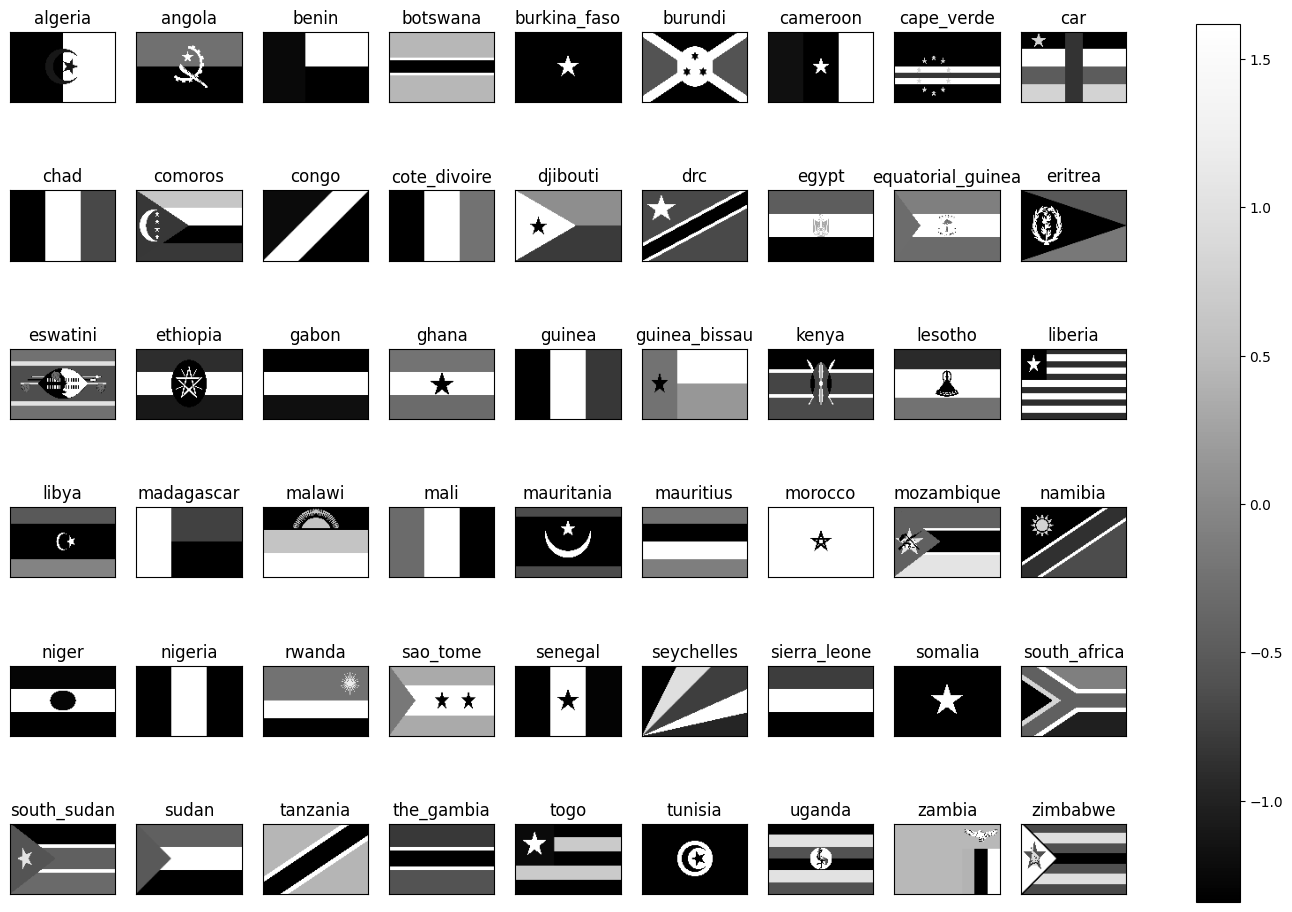

In [31]:
flags = pickle.load(open("flags_of_africa.pickle","rb"))
print("Flags data successful loaded!")
fig, ax = plot_patterns(flags)

In [32]:
# Initialise a new Hopfield network with the flags as patterns
HFN = HopfieldNetwork(flags)

n_steps: 5


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

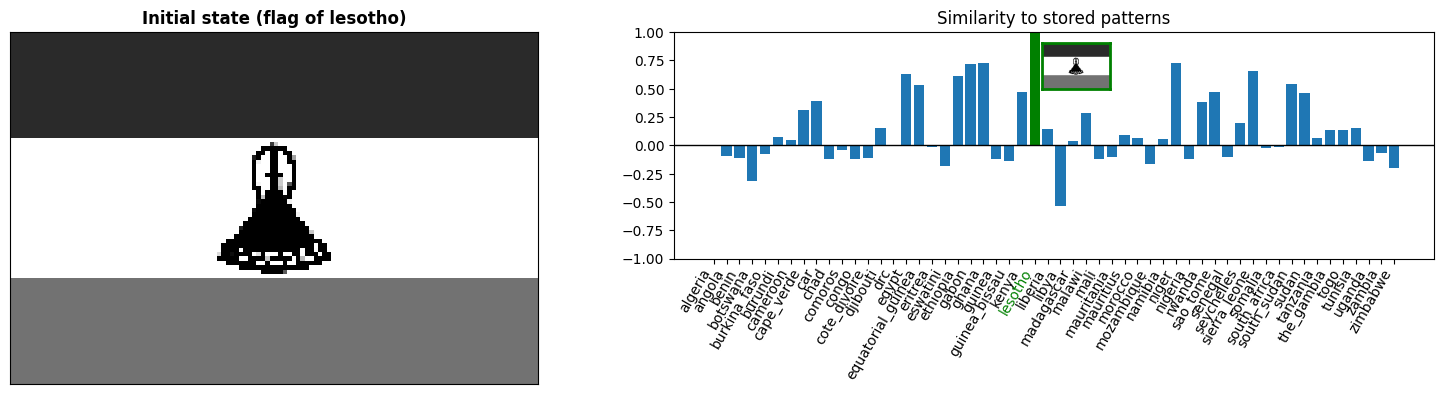

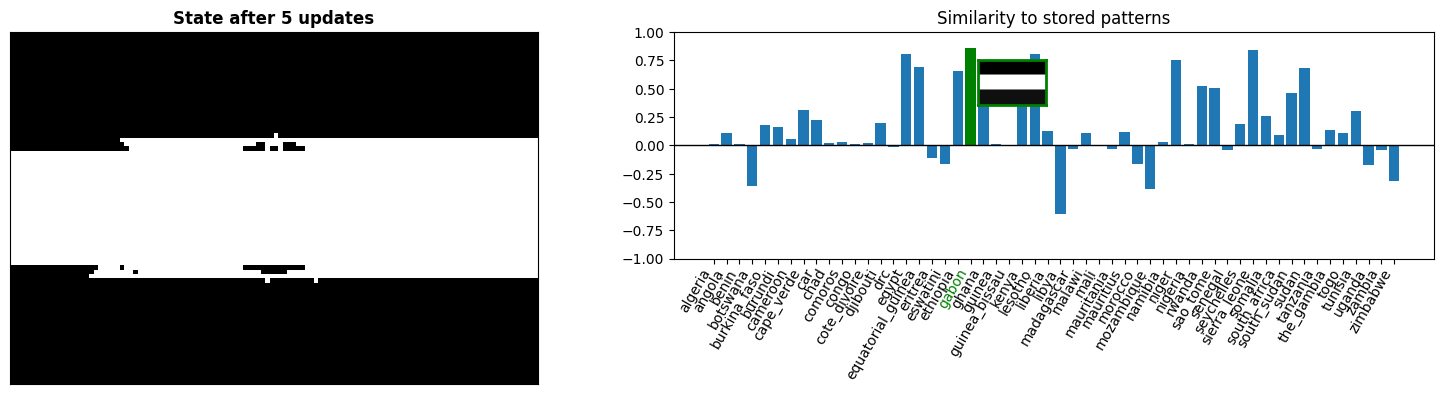

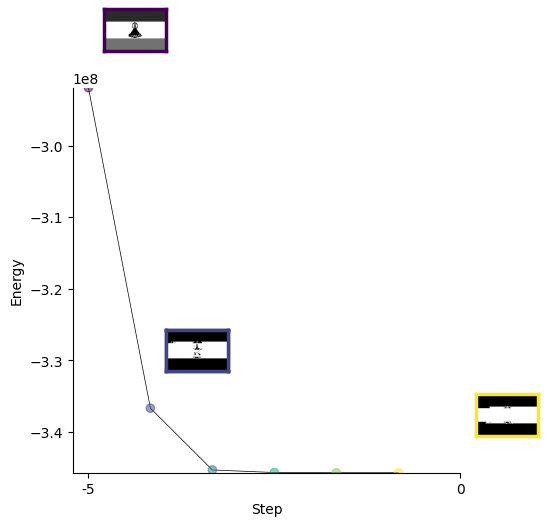

In [33]:
country = 'lesotho'
# country = 'south_africa'
# country = 'eswatini'

HFN.set_state(flags[country].flatten()) #reinitialise the state of the network
HFN.visualise(title=f"Initial state (flag of {country})")
for i in range(5):
    HFN.update_state(asynchronous=False)
HFN.visualise(title=f"State after {i+1} updates")

HFN.plot_energy(n_steps = 5)

#### Hmmmmm...not great. :(

Try with a few other countries.
Here's a few ideas for why the network might not perform very well at learning African flags:

* There's **too many** flags...we've exceeded the memory capacity of the network
    * Probably not. Theory tells us the capacity of a Hopfield Network is $N_{\textrm{capacity}} \approx 0.138 N_{\textrm{neurons}}$. Here there is one neuron for each pixel (150 x 100 = 15,000) and this is wayyyy bigger than the number of countries.
* The flags **aren't binary** (+1, -1) patterns.
    * This definitely doesn't help but the problems are more fundamental: patterns get corrupted, not just binarised.
* The flags are **too correlated**
    * This is probably it! Classical Hopfield Network theory only holds for _uncorrelated random_ patterns. But flags are very correlated (i.e. greyscale Cote d'Ivore ~ Guinea) and not random (all contain a lot of structure e.g. strips, stars etc. )
    
**_📝TASK_** Try and run the code above using _your_ countries flag and then some others. Which countries flags are hardest to learn? Which are easier?

---

## **4.0 Modern Hopfield Networks** <a name="modern"></a>

I turns out its possible to improve the performance of Hopfield networks. For a full discussion see this  [resource](https://ml-jku.github.io/hopfield-layers/).

_Modern Hopfield Networks_ have a slightly modified energy and update function compared to _Classical Hopfield Networks_

| | **Classic** | **Modern** |
| ----------- | ----------- | ----------- |
| **Update rule** | $ \vec{s} \leftarrow \textrm{sign}\big(\underbrace{\vec{\xi}\vec{\xi}^{\mathsf{T}}}_{\mathsf{w}}\vec{s}\big)$ | $\vec{s} \leftarrow \vec{\xi} \textrm{softmax}(\beta \vec{\xi}^{\mathsf{T}}\vec{s})$ |
| **Energy function** | $ E(\vec{s}) = \vec{s}^{\mathsf{T}}\underbrace{\vec{\xi}\vec{\xi}^{\mathsf{T}}}_{\mathsf{w}}\vec{s}$ | $E(\vec{s}) = -\textrm{lse}\big(\vec{\xi}^{\mathsf{T}}\vec{s}\big) + \frac{1}{2} \vec{s}^{\mathsf{T}}\vec{s}$ |

where softmax and lse are smooth continuous functions. You don't need to understand these functions or these equations except to realise that

* It's just another way to update networks of neurons. In both cases, the udates and energy of the network depend on
    * The state of the network, $\vec{s}$
    * The patterns, $\vec{\xi}$ (in the _classic_ case we used these to define a new quantity called the weight matrix $\mathsf{w} = \vec{\xi}\vec{\xi}^{\mathsf{T}}$



This class inherits from our original `HopfieldNetwork` class so we can use all the same plotting functions

In [ ]:
class ModernHopfieldNetwork(HopfieldNetwork):
    def __init__(self,patterns,beta=0.01):
        self.beta=beta
        super().__init__(patterns)

    def update_state(self):
        """This is the ONLY difference between ModernHopfieldNetwork and HopfieldNetwork. Igt has a slightly different update rule.
        Note the use of a softmax function to make the network dynamics more continuous"""

        self.state += 0.1 * (self.flattened_patterns.T @  softmax(self.beta * self.flattened_patterns @ self.state) - self.state)
        self.similarities = self.get_similarities()
        self.energy = self.get_energy()
        self.save_history()

    def get_energy(self,state=None):
        """Modern Hopfield Networks have slightly different energy functions. You can ignore this function for now."""
        state = self.state if state is None else state
        return -log_sum_exp(self.flattened_patterns @ state, beta=self.beta) + 0.5 * state @ state

In [ ]:
MHFN = ModernHopfieldNetwork(flags,
                             beta=0.05, #the "inverse temperature"
                            )


In [ ]:
MHFN.set_state(random=True) #reinitialise the state of the network
MHFN.visualise(title=f"Initial random state")
for i in range(50):
    MHFN.update_state()
MHFN.visualise(title=f"State after {i+1} updates")
fig, ax = MHFN.plot_energy(n_steps=i+1)

Lets try mask a flag and set it it can "pattern complete" it.

**_📝TASK_** Complete the following code to maskl the flag of your chosen country. Simulate the network then animate it to see if it "remembers" the flag.


In [ ]:
# 1. Choose a country
country = flags["chose_your_country_here"]

# 2. Create a masked flag of this country using the mask_pattern()
masked_flag = # your code goes here

# 3. Set the state using MHFN.set_state()
# your code goes here

# 4. Update the Modern Hopfield Network for 20 steps using MHFN.update_state()
# your code goes here

# Animate the network using MHFN.animate(n_steps=20)
# your code goes here

In [ ]:
#@title Double click to reveal answer {display-mode: "form" }
country = "nigeria"
masked_flag = mask_pattern(flags[country])# your code here
MHFN.set_state(masked_flag)
#now update the Modern Hopfield Network for 20 states
for i in range(20):
    MHFN.update_state()

MHFN.animate(n_steps=20)

### **4.1 Flag Championship!!** <a name="flag-championship"></a>

Nigeria 🇳🇬 and Ghana 🇬🇭 have long argued over who has the best jollof rice. Algeria 🇩🇿 and Tunisia 🇹🇳 over who has the best couscous. Cameroon 🇨🇲 and Egypt 🇪🇬 over who has the best football team.

Can we settle these debates once and for all? Probably not.

Can we add computational neuroscience inspired fuel to the fire? Probably! 🔥

The `merge_pattterns(pattern1, pattern2)` function combines two pattern (half on the left half on the right).

If we initialise the network in this merged state, which flag will network converge to? Only dynamics will tell...


In [ ]:
country1 = 'eswatini'
country2 = 'mauritania'

merged_flag = merge_patterns(flags[country1],flags[country2])

MHFN = ModernHopfieldNetwork(flags)
MHFN.set_state(merged_flag)
MHFN.visualise(title=f"Initial state (merged flags of {country1} and {country2})")
for i in range(50):
    MHFN.update_state()

MHFN.animate(n_steps=50)

In [ ]:
#test which is most similar
flag_names = np.array(list(flags.keys()))
country1_score, country2_score = MHFN.similarities[flag_names == country1][0], MHFN.similarities[flag_names == country2][0]
print(f"The winner is....{country1.upper() if country1_score > country2_score else country2.upper()}!")

### **4.2 The "inverse-temperature", $\beta$** <a name="temperature"></a>

In the update function for the Modern Hopfield Network we use a scalar quantity called $\beta$. THis is often called the "inverse temperate.

* High values of $\beta$ correspond to a _low temperatures_ and mean that the attraction basins of the individual patterns remain separated. It is unlikely that metastable states appear.
* Low values of $\beta$ on the other hand correspond to a high temperature and the formation of metastable states becomes more likely.

**_📝TASK_** Try the above but with a much _higher_ temperature (i.e. a _lower_ $\beta$, try $\beta \leftarrow 0.001$). What happens?


**_📝TASK_** These flags have to be in greyscale. How might we upgrade this network to allow it to remember coloured patterns? Discuss this with your neighbour.

---

## **Congrats!**
Well done. You made it to the end of the tutorial!

### **Re-use**
Feel free you to adapt and use this tutorial for your own teaching need!

### **About the author: Tom George**
* Feel free to get in touch at tom.george.20@ucl.ac.uk
* Links: [Twitter](https://twitter.com/TomNotGeorge), [Github](https://github.com/TomGeorge1234), [Google Scholar](https://scholar.google.com/citations?user=AG49j3MAAAAJ&hl=en)